In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from torchvision.transforms import *
from PIL import Image

In [3]:
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim

In [4]:
class ParticleSeg(Dataset):
    
    def __init__(self, root_dir:str, transforms:object=None):
        
        super().__init__()
        
        self.root_dir = root_dir
        self.transforms_mask = transforms
        self.transforms_img = transforms
        
        self.mask_dir = os.path.join(root_dir, "segmaps")
        self.img_dir = os.path.join(root_dir, "images")
        
        self.file_names = os.listdir(self.mask_dir)
        self.mask_paths = [os.path.join(self.mask_dir, mask_name) for mask_name in self.file_names]
        self.img_paths = [os.path.join(self.img_dir, img_name) for img_name in self.file_names]
   

    def __len__(self):
        
        return len(self.file_names)
    
    def __getitem__(self, ix:int):
        
        seed = np.random.randint(2022)
        random.seed(seed)
        torch.manual_seed(seed)
        
        mask_path, img_path = self.mask_paths[ix], self.img_paths[ix]
        
        mask, img = Image.open(mask_path), Image.open(img_path)
        
        if self.transforms_img is not None:
        
            img = self.transforms_img(img)
            
        random.seed(seed)
        torch.manual_seed(seed)
        
        if self.transforms_mask is not None:
            
            mask = self.transforms_mask(mask)
        
        mask, img = mask.long(), img[[0]].float()
        
        mask[mask>0]=1
        img = img / 255
            
        return img, mask
        

In [5]:
transforms = Compose([
    
#     Resize((256,256)),
    Resize((160,160)),
    RandomRotation(45),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    GaussianBlur(5),
    PILToTensor(),
    
    
])

In [6]:
dataset = ParticleSeg(root_dir='/kaggle/input/electron-microscopy-particle-segmentation', transforms=transforms)

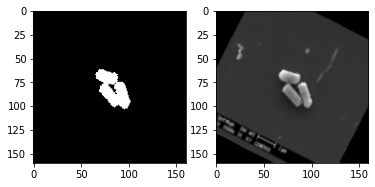

In [7]:
mask, img = dataset[100]

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(img.permute((1, 2, 0)), cmap = 'gray')
ax[1].imshow(mask.permute((1, 2, 0)), cmap= 'gray')

In [8]:
#Split the dataset into train and validation
dataset_train, dataset_val = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

In [9]:
dataloader_train = DataLoader(dataset_train, batch_size = 32)
dataloader_val = DataLoader(dataset_val, batch_size = 32)

In [10]:
# Class represents the double convolutions at each level
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        
        self.conv = nn.Sequential(
            # same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.conv(x) 

In [11]:
class Unet(nn.Module):
    
    def __init__(
        self, in_channels=1, out_channels=2, features=[64,128,256,512]
    ):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Encoder
        for feature in features:
            self.encoder.append(
                DoubleConv(in_channels, feature)
            )
            in_channels = feature
        
        #Decoder
        for feature in features[::-1]:
            
            self.decoder.append(
            nn.ConvTranspose2d(
                #because the skip connections are also should be added, that's why feature is multiplied by 2
                # kernel and stride equal 2 increase the size of the image by 2
                feature*2, feature, kernel_size=2, stride=2
            )
            )
            self.decoder.append(
                DoubleConv(feature*2, feature)
            )
        
        self.bottle_neck = DoubleConv(features[-1], features[-1]*2)
        self.output_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        
        skip_connections = []
        for encoder in self.encoder:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottle_neck(x)
        skip_connections = skip_connections[::-1]
        
        for i in np.arange(len(self.decoder), step=2):
            #Upsampling
            x = self.decoder[i](x)
            skip_connection = skip_connections[i//2]
            #Concatenate skip connection with upsampled image
            concatenate_skip = torch.cat((skip_connection, x), dim=1)
            # Double Conv
            x = self.decoder[i+1](concatenate_skip)
            
        return self.output_conv(x)


In [155]:
# TRAINING

#Hyperparameters
LR = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16
epochs = 25
LOAD_MODEL = False


In [122]:
def train(loader, model, optimizer, loss_fn, scaler):
    
    for batch, (imgs, masks) in enumerate(tqdm(loader)):
        imgs = imgs.to(device)
        masks = masks.float().to(device)
        
        #forward path
#         with torch.cuda.amp.autocast():
        preds = model(imgs)
#         print(torch.unique(masks))
#         print(preds.shape, masks.shape)
        loss = loss_fn(preds, masks)
        
        #backward path
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

In [119]:
model = Unet(in_channels=1, out_channels=1).to(device) #,features=[16,32,64,128]).to(device)
loss_fn = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss(weight=torch.tensor([1.0,1.0]).to(device))
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [120]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("-> Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model):
    print("-> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [100]:
def check_accuracy(loader, model, device="cuda"):
    correct, pixels = (0,0)
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            preds = model(x)
            preds = (preds > 0.5).float()
            correct += (preds == y).sum()
            pixels += torch.numel(preds)
            dice_score += (2* (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            
    print(f"Accuracy: {100*correct/pixels:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
    

In [101]:
def check_img_predictions(loader, model, path="./results", device="cuda"):
    
    model.eval()
    for i, (x,y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            preds = model(x)
            preds = (preds>0.5).float()
        torchvision.utils.save_image(
            preds, f"{path}/pred_res_{i}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{path}/y_res_{i}.png")
    model.train()

In [156]:
if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(epochs):
    train(dataloader_train, model, optimizer, loss_fn, scaler)
    
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    
    #save_checkpoint(checkpoint)
    check_accuracy(dataloader_val, model, device)

100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


Accuracy: 92.76
Dice score: 0.8885554075241089


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


Accuracy: 92.97
Dice score: 0.8918332457542419


100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Accuracy: 92.69
Dice score: 0.8832038640975952


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Accuracy: 94.37
Dice score: 0.9101806879043579


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


Accuracy: 92.88
Dice score: 0.8855890035629272


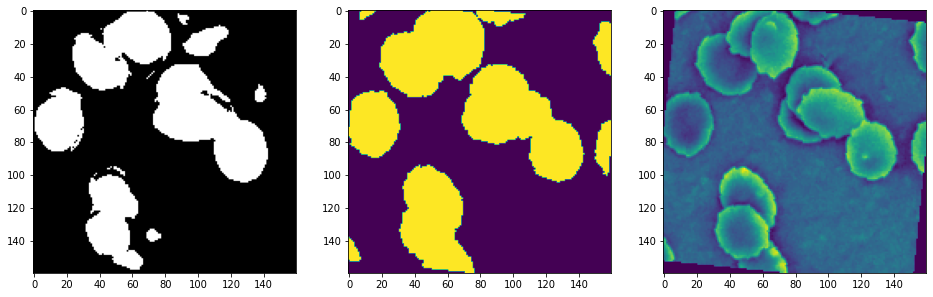

In [154]:
i = np.random.randint(32)
for x, target in dataloader_val:
    pred = model(x[[i]].to(device)).cpu().squeeze().detach()
    
    #pred = torch.argmax(pred, dim=1).squeeze().numpy()
    pred = torch.where(pred > 0.5, 1, 0).squeeze()
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    
    ax[0].imshow(pred, cmap='gray')
    ax[1].imshow(target[[i]].squeeze())
    ax[2].imshow(x[[i]].squeeze())
    ""
    break